In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [1]:
import polars as pl
from tqdm import tqdm
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy

# Insall Pyspark

In [ ]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
import findspark
findspark.init()
findspark.find()
import pyspark
from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark= SparkSession \
       .builder \
       .appName("Our First Spark Example") \
       .getOrCreate()

spark

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,387 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:13 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:14 http://security.ubuntu.com/ubuntu jam

# 1. Tải và đọc file dữ liệu user.json

In [2]:
# Đọc file JSON theo từng phần (chunk) 100.000 dòng
chunk_size = 100000
chunks = pd.read_json('user.json', lines=True, chunksize=chunk_size)

# Xử lý từng chunk, ví dụ: gộp các chunk lại thành một DataFrame lớn hơn nếu cần
user_df = pd.concat(chunks, ignore_index=True)

In [ ]:
user_df.head()

,id,name,gender,school,year_of_birth,course_order,enroll_time
0,U_22,我,0.0,,2015.0,"[682129, 2294668]","[2019-10-12 10:28:02, 2020-11-21 14:03:28]"
1,U_24,王帅国,1.0,清华大学,6558.0,"[597214, 605512, 597211, 597314, 597208, 62950...","[2019-05-20 16:06:48, 2019-05-24 19:34:43, 201..."
2,U_25,王帅国,0.0,清华大学,NaN,[1903985],[2020-08-07 18:59:13]
3,U_53,于歆杰,1.0,清华大学,1973.0,"[696679, 1704639, 943255, 1729417, 682164, 177...","[2020-03-01 21:24:30, 2020-03-12 16:17:02, 202..."
4,U_54,马昱春,2.0,清华大学,NaN,"[682442, 682164, 1748240, 1778890, 1829031, 17...","[2019-10-09 02:17:49, 2019-11-08 00:49:03, 202..."


In [3]:
cleaned_user_df = user_df.drop(columns=['name', 'gender', 'school', 'year_of_birth', 'enroll_time'])
cleaned_user_df.head()

,id,course_order
0,U_22,"[682129, 2294668]"
1,U_24,"[597214, 605512, 597211, 597314, 597208, 62950..."
2,U_25,[1903985]
3,U_53,"[696679, 1704639, 943255, 1729417, 682164, 177..."
4,U_54,"[682442, 682164, 1748240, 1778890, 1829031, 17..."


# Các cột file dữ liệu

In [ ]:
user_df.columns

Index(['id', 'name', 'gender', 'school', 'year_of_birth', 'course_order',
       'enroll_time'],
      dtype='object')

In [ ]:
user_df.shape

(3330294, 7)

### **Nhận xét:**
File user.json gồm 3330294 dòng và 7 cột bao gồm 'course_order','enroll_time' ,'gender', 'id','name','school', 'year_of_birth'

In [ ]:
user_df.describe()

,gender,year_of_birth
count,3.330240e+06,48530.000000
mean,9.455748e-01,2039.016299
std,8.321099e-01,358.674303
min,0.000000e+00,1111.000000
25%,0.000000e+00,2020.000000
50%,1.000000e+00,2020.000000
75%,2.000000e+00,2020.000000
max,2.320000e+02,9989.000000


In [ ]:
user_df.dtypes

,0
id,object
name,object
gender,float64
school,object
year_of_birth,float64
course_order,object
enroll_time,object


# 2. Phân tích từng cột trong dữ liệu

## Cột id

In [ ]:
user_df['id'].value_counts()

,count
id,
U_22,1
U_27708714,1
U_27708685,1
U_27708690,1
U_27708691,1
...,...
U_14910652,1
U_14910654,1
U_14910657,1


Nhận xét: cột id không có giá trị trùng lặp

## Cột year_of_birth

In [ ]:
user_df['year_of_birth'].value_counts()

,count
year_of_birth,
2020.0,46524
2016.0,443
1997.0,258
1996.0,187
1998.0,141
...,...
1692.0,1
6622.0,1
5764.0,1


In [ ]:
min_year_of_birth = user_df['year_of_birth'].min()
max_year_of_birth = user_df['year_of_birth'].max()

print(f"Min year of birth: {min_year_of_birth}")
print(f"Max year of birth: {max_year_of_birth}")

Min year of birth: 1111.0
Max year of birth: 9989.0


In [ ]:
count_in_range = user_df[(user_df['year_of_birth'] >= 1111) & (user_df['year_of_birth'] <= 9989)].shape[0]

print(f"Số lượng các user có năm sinh từ 1111 đến 9989: {count_in_range}")

Số lượng các user có năm sinh từ 1111 đến 9989: 48530


### Số giá trị năm sinh gồm 253 giá trị và có miền giá trị là [1111,9989]. Điều này là không hợp lí -> Tiến hành lọc dữ liệu với các bộ có miền giá trị năm sinh rơi vào [1950,2024]

### Số lượng các user có năm sinh từ 1950 đến 2024

In [ ]:
count = user_df[(user_df['year_of_birth'] >= 1950) & (user_df['year_of_birth'] <= 2024)].shape[0]
print(f"Số lượng các user có năm sinh từ 1950 đến 2024: {count}")

Số lượng các user có năm sinh từ 1950 đến 2024: 48330


### Chọn các bộ dữ liệu có năm sinh rơi vào khoảng [1950,2024]

In [ ]:
# Lọc các giá trị năm sinh nằm trong khoảng từ 1950 đến 2024
filtered_df = user_df[(user_df['year_of_birth'] >= 1950) & (user_df['year_of_birth'] <= 2024)]
value_counts = filtered_df['year_of_birth'].value_counts().sort_index()
count_distinct_values = len(value_counts)

print(f"Số lượng các giá trị riêng biệt: {count_distinct_values}")
value_counts

Số lượng các giá trị riêng biệt: 57


,count
year_of_birth,
1950.0,1
1960.0,1
1961.0,1
1962.0,2
1963.0,1
1964.0,2
1965.0,6
1966.0,2
1967.0,2


Có 57 giá trị năm sinh riêng biệt trong khoảng [1950,2024]

## Vẽ biểu đồ cột thể hiện số người học MOOC có năm sinh trong khoảng [1950,2024]

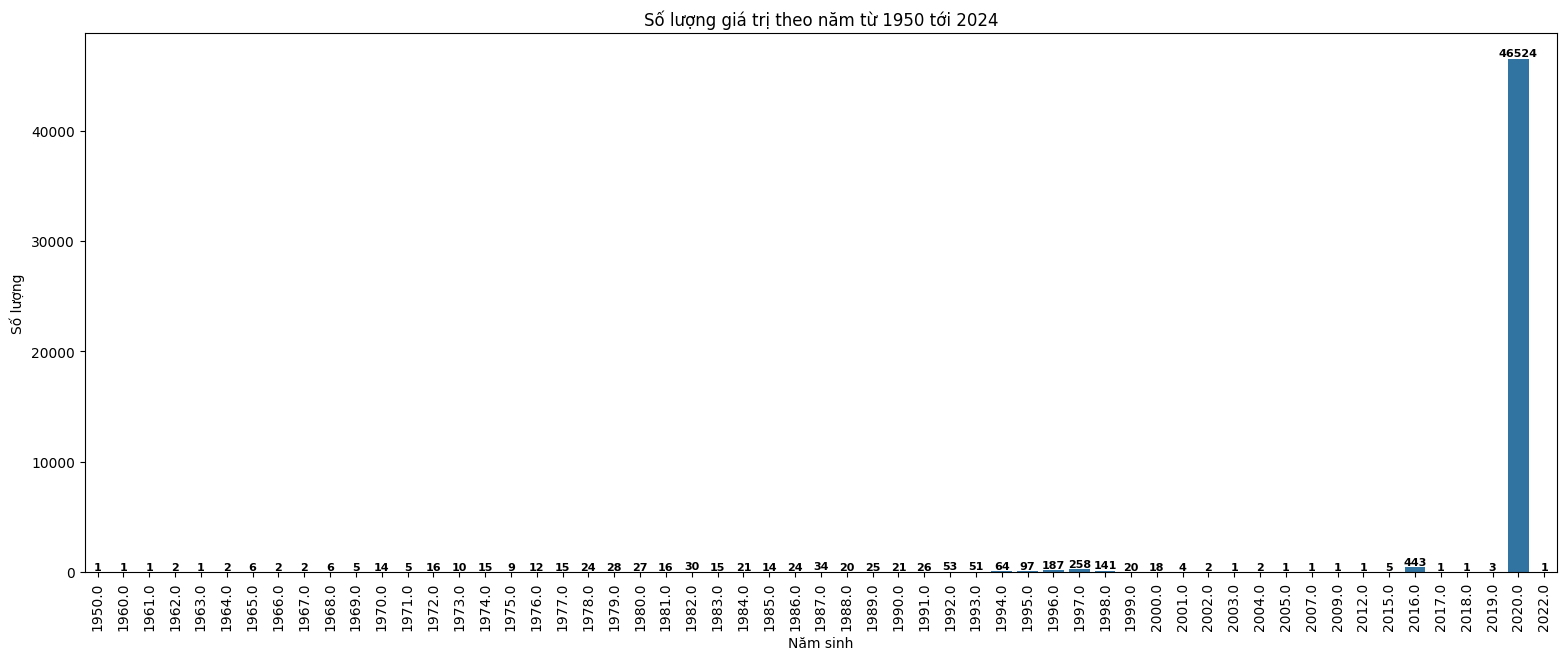

In [ ]:
value_counts_df = value_counts.reset_index()
value_counts_df.columns = ['year_of_birth', 'count']

plt.figure(figsize=(19, 7))
ax = sns.barplot(x='year_of_birth', y='count', data=value_counts_df)
# Thêm chú thích là số giá trị trên đầu mỗi cột
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,  # Vị trí x giữa cột
        p.get_height() + 0.5,           # Vị trí y trên cột
        f'{int(p.get_height())}',      # Văn bản chú thích (làm tròn thành số nguyên)
        ha='center',                   # Căn chỉnh ngang
        va='bottom',                   # Căn chỉnh dọc
        fontweight='bold',             # Độ đậm
        fontsize = 8
    )
plt.xlabel('Năm sinh')
plt.ylabel('Số lượng')
plt.title('Số lượng giá trị theo năm từ 1950 tới 2024')
plt.xticks(rotation = 90)
plt.show()

Nhận thấy số lượng người học có năm sinh 2020 là quá cao. Vì thế chúng em tiến hành bỏ qua cột 2020 để đồ thị trực quan hơn

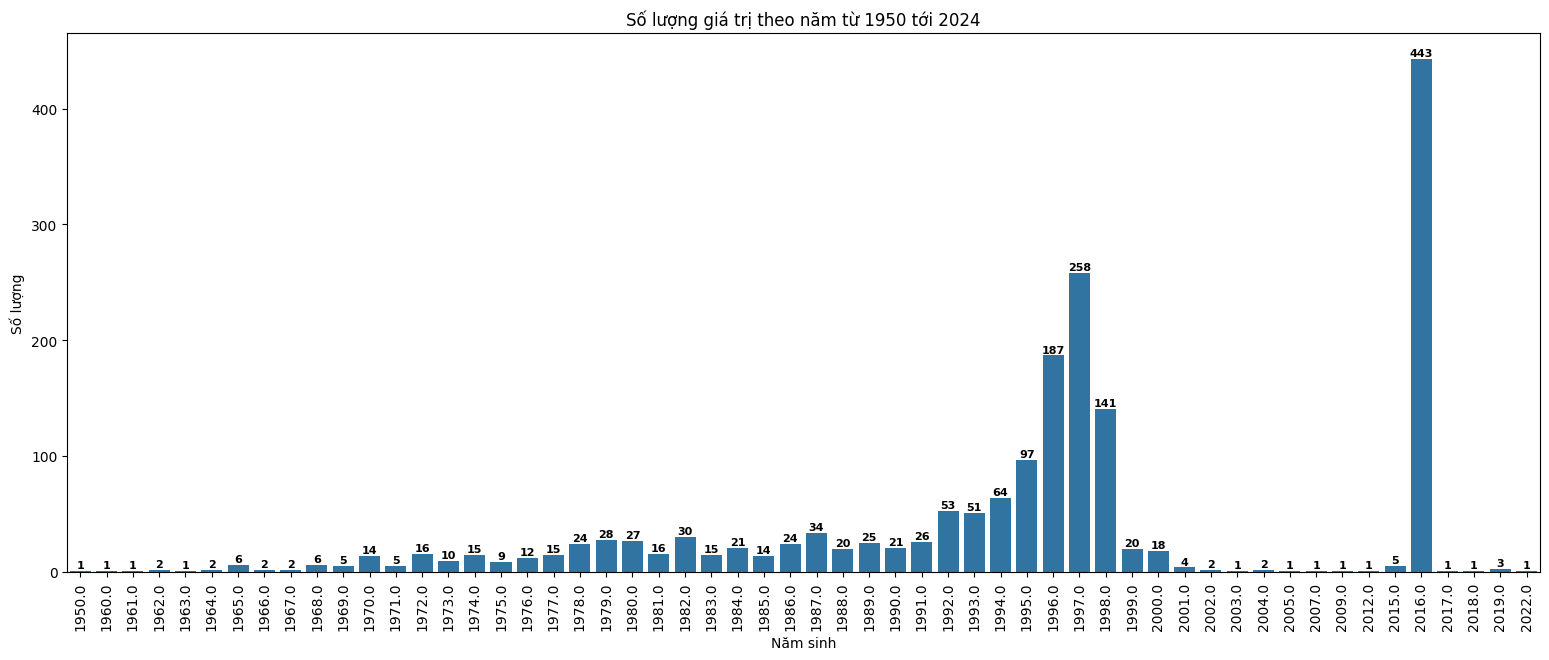

In [ ]:
filtered_df = user_df[(user_df['year_of_birth'] >= 1950) & (user_df['year_of_birth'] <= 2024) & (user_df['year_of_birth'] != 2020)]
value_counts = filtered_df['year_of_birth'].value_counts().sort_index()
value_counts_df = value_counts.reset_index()
value_counts_df.columns = ['year_of_birth', 'count']

plt.figure(figsize=(19, 7))
ax = sns.barplot(x='year_of_birth', y='count', data=value_counts_df)
# Thêm chú thích là số giá trị trên đầu mỗi cột
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,  # Vị trí x giữa cột
        p.get_height() + 0.5,           # Vị trí y trên cột
        f'{int(p.get_height())}',      # Văn bản chú thích (làm tròn thành số nguyên)
        ha='center',                   # Căn chỉnh ngang
        va='bottom',                   # Căn chỉnh dọc
        fontweight='bold',             # Độ đậm
        fontsize = 8
    )
plt.xlabel('Năm sinh')
plt.ylabel('Số lượng')
plt.title('Số lượng giá trị theo năm từ 1950 tới 2024')
plt.xticks(rotation = 90)
plt.show()

# Cột course_order

Cột course_order gồm 1 mảng bao gồm các id khóa học mà người học(id) đã chọn.

In [ ]:
user_df['course_order']

,course_order
0,"[682129, 2294668]"
1,"[597214, 605512, 597211, 597314, 597208, 62950..."
2,[1903985]
3,"[696679, 1704639, 943255, 1729417, 682164, 177..."
4,"[682442, 682164, 1748240, 1778890, 1829031, 17..."
...,...
3330289,"[697791, 782490, 799796]"
3330290,[2199449]
3330291,[916828]
3330292,[735405]


### Thống kê số người học dựa trên số lượng khóa học

In [ ]:
all_courses = user_df['course_order'].explode()
course_counts = all_courses.value_counts()
print("Số lượng người học theo từng khóa học:")
course_counts

Số lượng người học theo từng khóa học:


,count
course_order,
936971,231674
696994,181697
676932,125789
697791,96210
883345,78374
...,...
681866,1
681867,1
681870,1


### Tính toán các số liệu như giá trị trung bình, độ lệch chuẩn, giá trị nhỏ nhất, lớn nhất.

In [ ]:
course_counts.describe()

,count
count,4701.000000
mean,2511.612423
std,7232.724744
min,1.000000
25%,7.000000
50%,264.000000
75%,2171.000000
max,231674.000000


### Tiến hành lọc số các khóa học có số người học lớn hơn 1.

In [ ]:
course_counts = course_counts[course_counts > 1]
course_counts

,count
course_order,
936971,231674
696994,181697
676932,125789
697791,96210
883345,78374
...,...
688430,2
681560,2
629540,2


In [ ]:
course_counts_df = course_counts.reset_index()
course_counts_df.columns = ['course_order', 'count']
course_counts_df

,course_order,count
0,936971,231674
1,696994,181697
2,676932,125789
3,697791,96210
4,883345,78374
...,...,...
3789,688430,2
3790,681560,2
3791,629540,2
3792,737494,2


Nhận xét:
* Có 907 user chỉ tham gia một khóa học cho thấy một phần không nhỏ người học có xu hướng chỉ đăng ký và hoàn thành một khóa học duy nhất. Điều này có thể phản ánh sở thích học tập ngắn hạn, sự quan tâm cụ thể, hoặc thiếu nhu cầu tiếp tục học thêm.
* Có những khóa học được đăng ký rất nhiều, vượt xa số lượng của các khóa học khác, cụ thể như khóa học 936971 có số lượng user tham gia là 231674.

### Đồ thị thống kê số người học theo số lượng khóa học (số lượng khóa học rất nhiều nên nhóm chỉ trực quan 30 khóa học đầu tại vì những khóa học sau đều có số lượng tham gia rất ít)

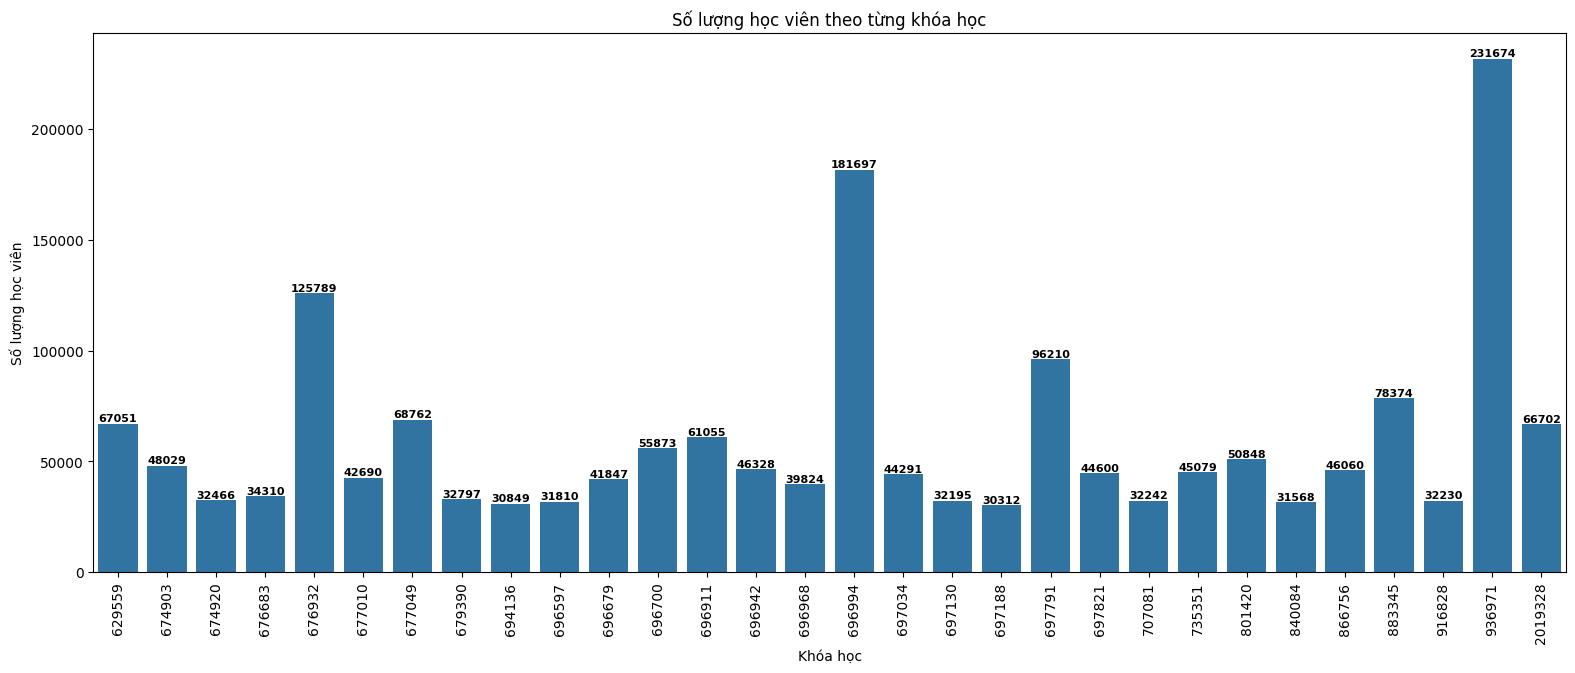

In [ ]:

plt.figure(figsize=(19, 7))
ax = sns.barplot(x='course_order', y='count', data=course_counts_df[:30])
# Thêm chú thích là số giá trị trên đầu mỗi cột
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,  # Vị trí x giữa cột
        p.get_height() + 0.5,           # Vị trí y trên cột
        f'{int(p.get_height())}',      # Văn bản chú thích (làm tròn thành số nguyên)
        ha='center',                   # Căn chỉnh ngang
        va='bottom',                   # Căn chỉnh dọc
        fontweight='bold',             # Độ đậm
        fontsize = 8
    )
plt.xlabel('Khóa học')
plt.ylabel('Số lượng học viên')
plt.title('Số lượng học viên theo từng khóa học')
plt.xticks(rotation = 90)
plt.show()

# Cột Gender(giới tính)

In [ ]:
user_df['gender'].value_counts()

,count
gender,
0.0,1221931
1.0,1067858
2.0,1040449
232.0,1
3.0,1


Gender có giá trị từ [0,2] chiếm đa số. Vì file readme github không nói rõ cụ thể các giá trị thuộc giới tính nào nên chúng em xin mặc định 0,1,2 là các giá trị giới tính hợp lệ. Tiến hành bỏ các giá trị không hợp lệ và vẽ đồ thị.

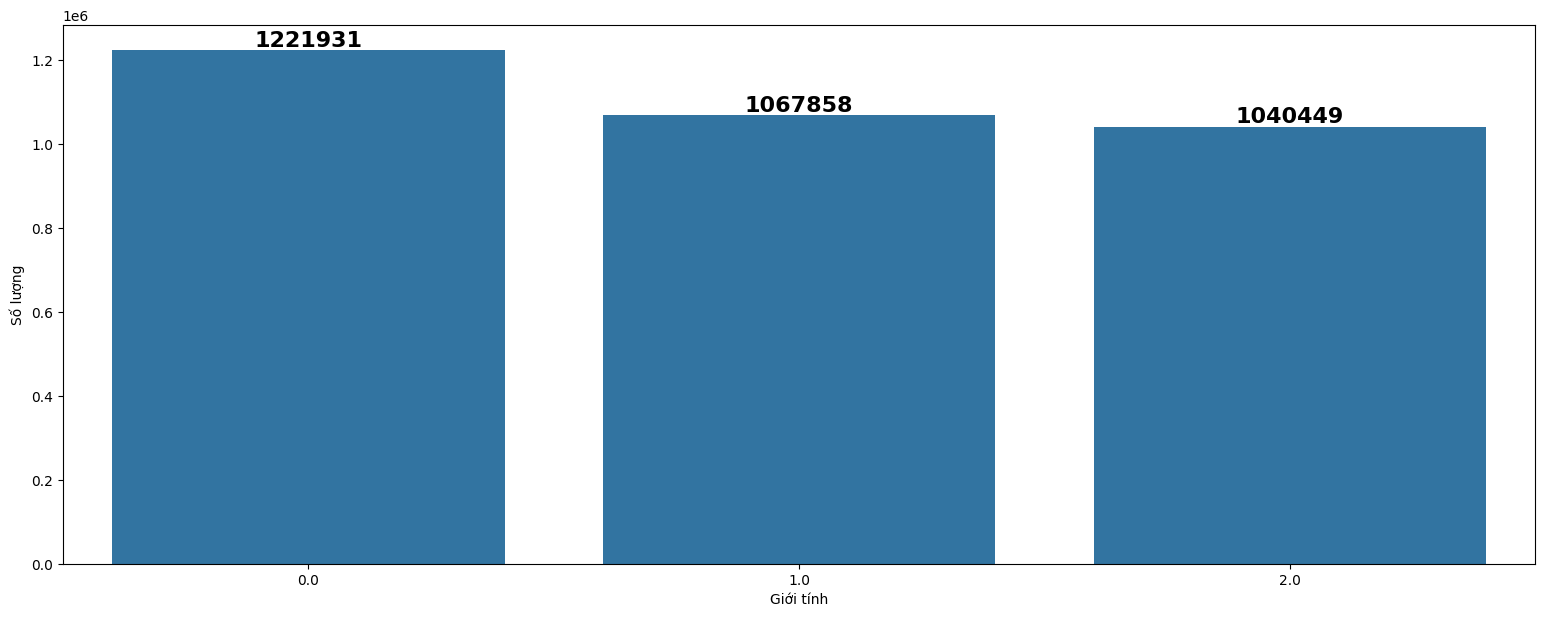

In [ ]:
count_gender = user_df['gender'].value_counts()
count_gender_df = count_gender.reset_index()
count_gender_df.columns = ['gender', 'count']
count_gender_df
# Vẽ biểu đồ cột
plt.figure(figsize=(19, 7))
ax = sns.barplot(x='gender', y='count', data=count_gender_df[:3])
# Thêm chú thích là số giá trị trên đầu mỗi cột
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,  # Vị trí x giữa cột
        p.get_height() + 0.5,           # Vị trí y trên cột
        f'{int(p.get_height())}',      # Văn bản chú thích (làm tròn thành số nguyên)
        ha='center',                   # Căn chỉnh ngang
        va='bottom',                   # Căn chỉnh dọc
        fontweight='bold',             # Độ đậm
        fontsize = 16
    )
plt.xlabel('Giới tính')
plt.ylabel('Số lượng')
plt.show()

# Cột School

In [ ]:
count_school = user_df['school'].value_counts()
count_school_df = count_school.reset_index()
count_school_df.columns = ['school', 'count']
count_school_df

,school,count
0,,2201841
1,清华大学,18412
2,昆明理工大学,15351
3,湖南大学,13388
4,河南工业大学,10198
...,...,...
24968,faw-vw,1
24969,Xinxiang Medical University,1
24970,现在工程学院,1
24971,长征职业技术学院,1


## Chọn những school có số lượng user theo học nhiều hơn 4000

In [ ]:
other = count_school_df[count_school_df['count'] <= 4000]
count_school_df = count_school_df[count_school_df['count'] > 4000]
count_school_df.index = range(0,len(count_school_df) )
count_school_df

,school,count
0,,2201841
1,清华大学,18412
2,昆明理工大学,15351
3,湖南大学,13388
4,河南工业大学,10198
5,河北工业大学,9857
6,广西科技大学,9331
7,华南理工大学,8896
8,陕西工业职业技术学院,8804
9,重庆大学,8661


## Vì số lượng file user.json quá lớn và cột school không liên quan đến đề tài `Dự đoán mức độ hài lòng đối với 1 khóa học` của nhóm nên chỉ sẽ dịch để biết school đó là school nào

In [ ]:
import torch
from transformers import MarianTokenizer, MarianMTModel
from concurrent.futures import ThreadPoolExecutor
import pandas as pd

# Load the translation model and tokenizer
tokenizer_zh2vi = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-zh-en")
model_zh2vi = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-zh-en")

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_zh2vi.to(device)
# Function to translate a Chinese sentence to Vietnamese
def translate_zh2vi(sentence, model, tokenizer, device):
    input_ids = tokenizer.encode(sentence, return_tensors="pt", padding=True, truncation=True).to(device)
    output_ids = model.generate(
        input_ids=input_ids,
        num_beams=5,
        early_stopping=True,
        max_length=256,  # Maximum length of the translated sentence
        no_repeat_ngram_size=3,  # Avoid repeating words in the translated sentence
        num_return_sequences=1  # Number of translation sequences to return
    )
    translated_sentence = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return translated_sentence

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/805k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/807k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.62M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [ ]:
for i in range(0, len(count_school_df)):
  # Translate the sentence
   if count_school_df.iloc[i]['school'] == "": continue
   x = translate_zh2vi(count_school_df.iloc[i]['school'], model_zh2vi, tokenizer_zh2vi, device)
   count_school_df.loc[i,'school'] = x
   print(x)
count_school_df

Qinghua University
Kunming University of Technology
Hunan Universality
Henan Industrial University
Hebei Industrial University
Guangxi University of Technology
South China Polytechnic Universality
Tsangxi Industrial Social Technology Institute
Chongqing University
Hubei Institute of Technology
Harbin Industrial University
Xinjiang University
Xintai College.
Central and Southern University of Finance and Economic Law
Yangtze University
Linan Techer Training College
I'm sorry, Tutor College.
Southwest University of Technology
Sannan Medical School
Guizhou Medical University
Chengdu College of Chinise Medicine
Northeast Universality
Aoshima Universality
Guangzhou University of China Medicine
Guizhou Institute of Technology
Liaoning School of Foreign Economics and Trade
Chongqing San George College of Medicine
Unity of the Three Georges
Ningxia Universality
Hanjiang Techer Training College
University of Fertilizer Industries
Hunan City College
Chongqing College of Electronic Engineering
Fi

,school,count
0,,2201841
1,Qinghua University,18412
2,Kunming University of Technology,15351
3,Hunan Universality,13388
4,Henan Industrial University,10198
5,Hebei Industrial University,9857
6,Guangxi University of Technology,9331
7,South China Polytechnic Universality,8896
8,Tsangxi Industrial Social Technology Institute,8804
9,Chongqing University,8661


In [ ]:
count_school_sorted = count_school_df.sort_values(by='count', ascending=False, na_position='last')
count_school_sorted.index = range(0,len(count_school_sorted))
count_school_sorted

,school,count
0,,2201841
1,Qinghua University,18412
2,Kunming University of Technology,15351
3,Hunan Universality,13388
4,Henan Industrial University,10198
5,Hebei Industrial University,9857
6,Guangxi University of Technology,9331
7,South China Polytechnic Universality,8896
8,Tsangxi Industrial Social Technology Institute,8804
9,Chongqing University,8661


### Nhận xét: Có 2201841 người học không điền vào tên trường.

### Biểu đồ thể hiện số lượng user của mỗi trường

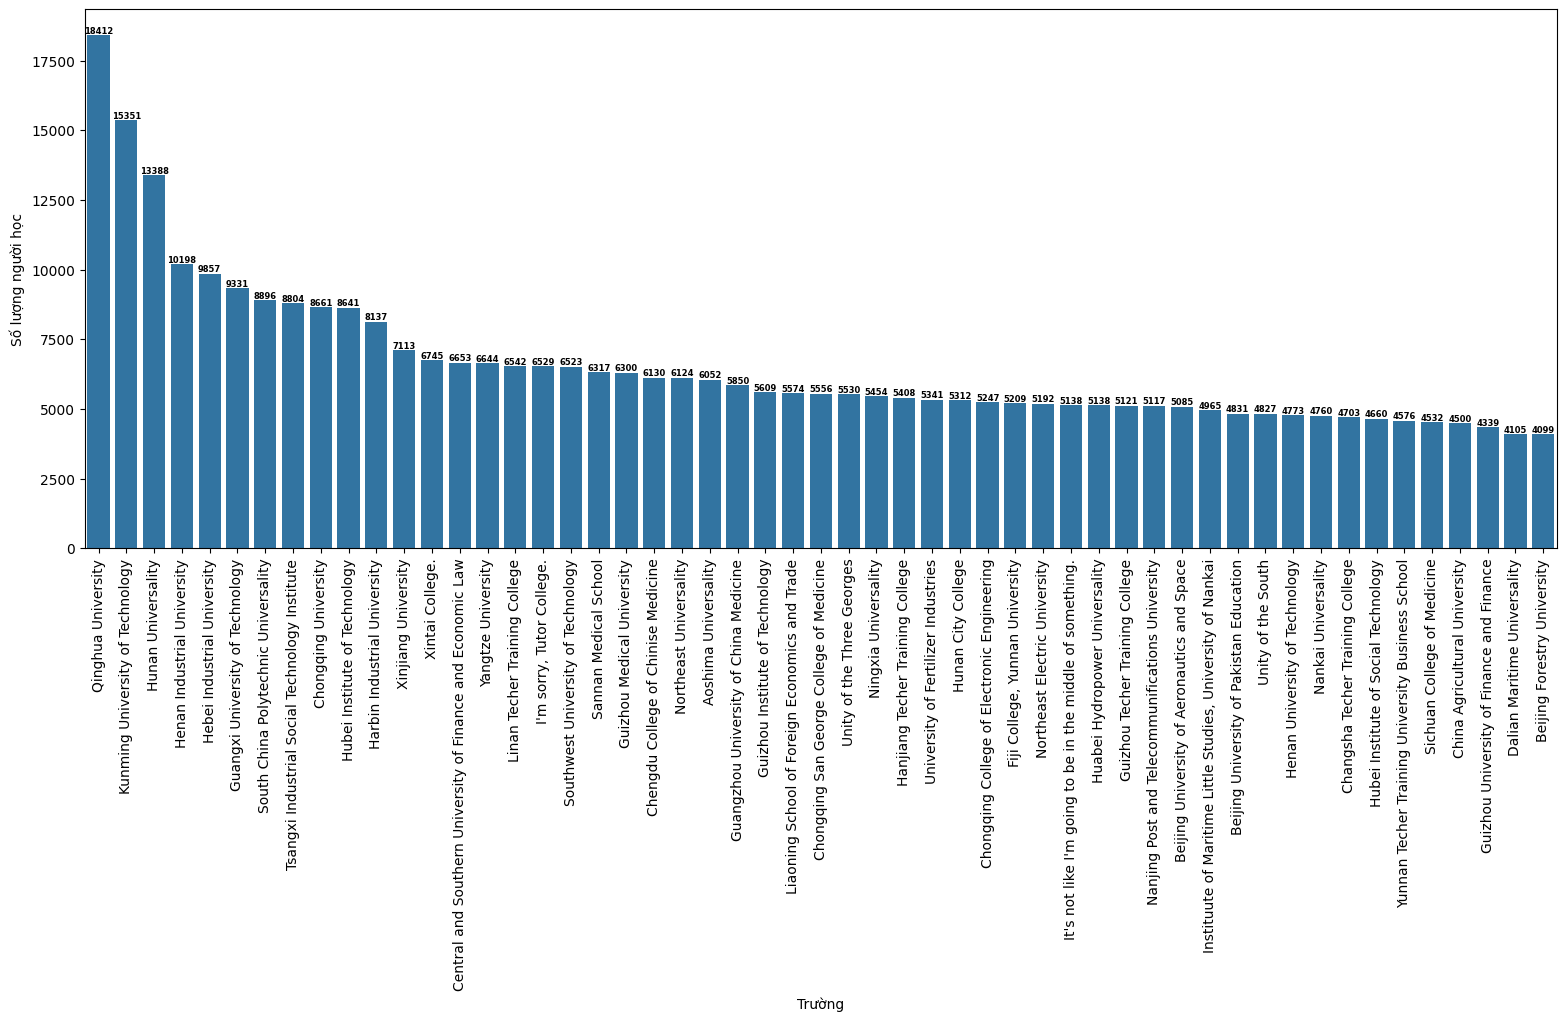

In [ ]:
# Vẽ biểu đồ cột
plt.figure(figsize=(19, 7))
ax = sns.barplot(x='school', y='count', data=count_school_sorted[1:len(count_school_sorted)])
# Thêm chú thích là số giá trị trên đầu mỗi cột
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,  # Vị trí x giữa cột
        p.get_height() + 0.5,           # Vị trí y trên cột
        f'{int(p.get_height())}',      # Văn bản chú thích (làm tròn thành số nguyên)
        ha='center',                   # Căn chỉnh ngang
        va='bottom',                   # Căn chỉnh dọc
        fontweight='bold',             # Độ đậm
        fontsize = 6
    )
plt.xlabel('Trường')
plt.ylabel('Số lượng người học')
plt.xticks(rotation = 90)
plt.show()
